In [1]:
from sklearn import tree # módulo de arvore de decisao
from sklearn import preprocessing # Modulo de preprocessamento
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
import pandas as pd # Pandas manipulação de dados
import os # acesso ao sistema operacional
import graphviz
import numpy as np

In [3]:
df = pd.read_csv( '../dia05/dados_candidatos.csv', sep=';', decimal=',' )

target = 'descricao_grau_instrucao'
features = [ 'descricao_cargo', 'descricao_cor_raca', 'descricao_estado_civil', 'descricao_genero',
                'sigla_uf_nascimento', 'nome_partido', 'patrimonio'  ]

group_names = { 'LE E ESCREVE': 'SEM ESCOLARIDADE',
                'ENSINO FUNDAMENTAL INCOMPLETO': 'SEM ESCOLARIDADE',
                'ENSINO MEDIO INCOMPLETO':'ENSINO FUNDAMENTAL COMPLETO',
                'SUPERIOR INCOMPLETO': 'ENSINO MEDIO COMPLETO' }

df[target] = df[target].apply( lambda x: group_names[x] if x in group_names else x )

# Agrupa suplentes
df['descricao_cargo'] = df['descricao_cargo'].replace( ['1o SUPLENTE SENADOR', '2o SUPLENTE SENADOR'], 'SUPLENTE SENADOR' )

In [4]:
cat_features = df[features].dtypes[df[features].dtypes == 'object'].index
onehot = preprocessing.OneHotEncoder(sparse=False)
onehot.fit( df[cat_features ] )
X = pd.DataFrame( onehot.transform( df[cat_features] ), columns = onehot.get_feature_names( cat_features ) )

num_features = df[features].dtypes[df[features].dtypes != 'object'].index
X[num_features] = df[num_features].copy()
X['declara_patrimonio'] = X['patrimonio'] > 0

# Definindo base de treino e base de teste

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split( X, df[target], test_size=0.2)

21770     True
28464    False
16206    False
2229      True
25443    False
         ...  
18428    False
24580    False
6314      True
21201    False
4508     False
Name: descricao_grau_instrucao, Length: 23268, dtype: bool

In [17]:
y_train = y_train == 'SUPERIOR COMPLETO'
y_test = y_test == 'SUPERIOR COMPLETO'

clf = tree.DecisionTreeClassifier()
clf.fit( X_train, y_train ) 

clf_rf = ensemble.RandomForestClassifier( n_estimators=500, max_depth=20, n_jobs=3 )
clf_rf.fit( X_train, y_train )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Definido acurácia na mão

In [59]:
result = pd.DataFrame( { 'predict': clf_rf.predict( X_train ) } )
result['y_true'] = y_train.reset_index(drop=True)

qtde_acertos = (result['predict'] == result['y_true']).sum()
qtde_obs = result.shape[0]

print("Acertamos {} individuos.".format( qtde_acertos ))
print("Dentre {} individuos.".format( qtde_obs ))

print("Logo, nossa acurácia é igual a: {} / {} = {}".format( qtde_acertos, qtde_obs, qtde_acertos / qtde_obs ) )

from sklearn import metrics
acc_sklearn = metrics.accuracy_score( result['y_true'], result['predict']  )

print("Acurácia calculada pelo sklearn:", acc_sklearn)

Acertamos 18920 individuos.
Dentre 23268 individuos.
Logo, nossa acurácia é igual a: 18920 / 23268 = 0.8131339178270586
Acurácia calculada pelo sklearn: 0.8131339178270586


In [60]:
pd.crosstab( result['y_true'], result['predict'] )

predict,False,True
y_true,,
False,10181,1771
True,2577,8739


In [61]:
precisao_true = 10382 / (114 + 10382)
print("Precisão Ensino superior:",precisao_true)

presicao_false = 11838 / ( 11838 + 934 )
print("Precisão NAO Ensino superior:",presicao_false)

Precisão Ensino superior: 0.9891387195121951
Precisão NAO Ensino superior: 0.9268712809270279


In [62]:
recall_superior_completo = 10382 / (934 + 10382)
print("Recall Superior:", recall_superior_completo)

recall_sem_superior = 11838 / (11838 + 114)
print("Recall SEM Superior:", recall_sem_superior)

Recall Superior: 0.9174620007069636
Recall SEM Superior: 0.9904618473895582


In [63]:
print("Métricas do SKLEARN")
print("Precision:", metrics.precision_score( result['y_true'], result['predict'] ) )
print("Recall:", metrics.recall_score( result['y_true'], result['predict'] ) )

Métricas do SKLEARN
Precision: 0.8314938154138916
Recall: 0.7722693531283139


## Curva ROC

In [65]:
pd.crosstab( result['y_true'], result['predict'] )

predict,False,True
y_true,,
False,10181,1771
True,2577,8739


In [64]:
sensibilidade = 10382 / (934 + 10382)
especificidade  = 11838 / (11838+114)

print("Sensibilidade:", sensibilidade)
print("especificidade:", especificidade)

Sensibilidade: 0.9174620007069636
especificidade: 0.9904618473895582


In [87]:
# Prevendo a probabilidade de ser ensino superior completo
proba = clf.predict_proba( X_train )

# Prevendo se é ou não ensino superior completo
predict = clf.predict( X_train )

In [84]:
print( metrics.classification_report( y_train, predict ) )

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     11952
        True       0.99      0.92      0.95     11316

    accuracy                           0.95     23268
   macro avg       0.96      0.95      0.95     23268
weighted avg       0.96      0.95      0.95     23268



In [91]:
print( metrics.classification_report( y_train, proba[:,1] > 0.99 ) )

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     11952
        True       1.00      0.90      0.95     11316

    accuracy                           0.95     23268
   macro avg       0.96      0.95      0.95     23268
weighted avg       0.95      0.95      0.95     23268



In [94]:
roc = metrics.roc_curve(y_train, proba[:,1] )

AttributeError: 'list' object has no attribute 'xlabel'

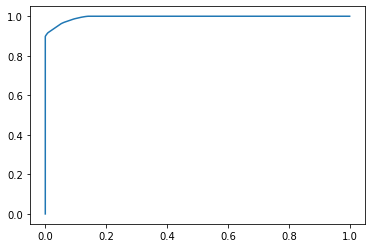

In [100]:
plot = plt.plot(  roc[0], roc[1])
plot.xlabel = '1 - especificidade'
plt.show()